# 2. Data Understanding



## 2.1 Collect initial data

For this question we've only used the Student questionnaire data (from 2022), collected from the folowing link: https://webfs.oecd.org/pisa2022/index.html

The dataset was originally in a .sas7bdat format and was converted to a .csv file.

In [2]:
"""
import pandas as pd

data = pd.read_sas(
    "../../../databases/2022/CY08MSP_STU_QQQ.sas7bdat", format="sas7bdat"
)
data.to_csv("../../../databases/2022/student2022.csv", index=False)

"""

'\nimport pandas as pd\n\ndata = pd.read_sas(\n    "../../../databases/2022/CY08MSP_STU_QQQ.sas7bdat", format="sas7bdat"\n)\ndata.to_csv("../../../databases/2022/student2022.csv", index=False)\n\n'

**Note:** We don't include these files in the project folder, so it's necessary to manually download and put them in their respective folder.

In [1]:
import pandas as pd

student = pd.read_csv('../../../databases/2022/STU_QQQ_SAS/student2022.csv')

## 2.2 Describe data

The original dataset has 1278 features

In [4]:
student.head(5)

,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT,VER_DAT
0,b'ALB',8.0,800282.0,800001.0,b'08MS',b'000800',b'ALB03',b'0080000',800.0,0.0,...,226.250,203.029,219.817,331.017,223.752,305.671,230.156,289.436,0.55561,b'03MAY23:10:11:25'
1,b'ALB',8.0,800115.0,800002.0,b'08MS',b'000800',b'ALB03',b'0080000',800.0,0.0,...,298.644,321.405,320.452,284.836,364.565,304.044,347.626,352.269,0.76431,b'03MAY23:10:11:25'
2,b'ALB',8.0,800242.0,800003.0,b'08MS',b'000800',b'ALB01',b'0080000',800.0,0.0,...,383.340,376.019,285.901,289.896,338.469,316.296,324.361,343.351,1.37877,b'03MAY23:10:11:25'
3,b'ALB',8.0,800245.0,800005.0,b'08MS',b'000800',b'ALB08',b'0080000',800.0,0.0,...,264.532,303.422,327.793,165.575,246.156,238.322,275.860,227.466,1.49361,b'03MAY23:10:11:26'
4,b'ALB',8.0,800285.0,800006.0,b'08MS',b'000800',b'ALB03',b'0080000',800.0,0.0,...,399.300,514.739,539.850,461.793,514.465,510.462,490.537,503.793,0.65249,b'03MAY23:10:11:26'


The dataset is composed by 1260 numeric columns and only 18 categorical columns. 

In [5]:
import pandas as pd
from tabulate import tabulate

categorical_columns = student.select_dtypes(include=["object", "category"]).columns
numeric_columns = student.select_dtypes(include=["int64", "float64"]).columns

column_types_df = pd.DataFrame(
    {
        "Column type": ["Numeric", "Categorical"],
        "Number of columns": [len(numeric_columns), len(categorical_columns) ],
        "Column names": [
            ", ".join(numeric_columns),
            ", ".join(categorical_columns),
        ],
    }
)

print(
    tabulate(
        column_types_df,
        headers="keys",
        tablefmt="pretty",
        showindex=False,
        colalign=("left", "left", "left"),
    )
)

+-------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
student.describe()

,CNTRYID,CNTSCHID,CNTSTUID,REGION,OECD,ADMINMODE,LANGTEST_QQQ,LANGTEST_COG,LANGTEST_PAQ,Option_CT,...,PV2MPRE,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT
count,613744.000000,6.137440e+05,6.137440e+05,613744.000000,613744.000000,613744.000000,602876.000000,613744.000000,93015.000000,613744.000000,...,592123.000000,592123.000000,592123.000000,592123.000000,592123.000000,592123.000000,592123.000000,592123.000000,592123.000000,613744.000000
mean,434.807781,4.348123e+07,4.342643e+07,43482.180478,0.480912,1.964772,319.202418,319.430137,276.268645,0.814416,...,442.271452,442.058179,442.014647,441.830879,442.035637,441.936271,442.161419,442.089600,442.073530,0.651738
std,255.846503,2.558506e+07,2.548515e+07,25585.242666,0.499636,0.184356,170.070303,172.095638,189.474771,0.388771,...,107.162477,107.411664,107.309852,107.613213,107.274656,107.179482,107.017426,107.333904,107.076819,0.405159
min,8.000000,8.000010e+05,8.000010e+05,800.000000,0.000000,1.000000,113.000000,113.000000,118.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.524000,0.000000,0.004990
25%,214.000000,2.140006e+07,2.140198e+07,21400.000000,0.000000,2.000000,156.000000,156.000000,156.000000,1.000000,...,363.976000,363.671500,363.810500,363.211000,363.566500,363.694000,364.194500,363.738000,364.147500,0.368080
50%,398.000000,3.980055e+07,3.981988e+07,39817.000000,0.000000,2.000000,313.000000,313.000000,232.000000,1.000000,...,437.279000,437.424000,436.909000,436.795000,437.057000,436.830000,437.336000,437.054000,437.074000,0.682440
75%,688.000000,6.880013e+07,6.880501e+07,68800.000000,1.000000,2.000000,449.000000,442.000000,313.000000,1.000000,...,516.985000,517.176500,516.823500,517.002500,516.858500,516.374000,516.996000,516.967500,516.440000,0.826460
max,901.000000,9.010018e+07,8.600749e+07,90100.000000,1.000000,2.000000,998.000000,998.000000,998.000000,1.000000,...,920.868000,940.027000,918.080000,906.043000,939.225000,904.258000,893.024000,943.962000,945.504000,11.643580


We can observe that there are a total of 613744 students, from which ~10% are repeating.

In [7]:
print(f"Total number of students: {len(student)}\n" )

not_repeating_students = student[student["REPEAT"] == 0]
print(f"Total number of non repeating students: {len(not_repeating_students)}")
student_grades = not_repeating_students["ST001D01T"].value_counts().reset_index()
student_grades.columns = ["Grade", "Count"]
print(student_grades)
print("\n")
repeating_students = student[student["REPEAT"] == 1]
print(f"Total number of repeating students: {len(repeating_students)}")
repeating_students_grades = repeating_students["ST001D01T"].value_counts().reset_index()
repeating_students_grades.columns = ["Grade", "Repeating"]
print(repeating_students_grades)

Total number of students: 613744

Total number of non repeating students: 518875
   Grade   Count
0   10.0  325584
1    9.0  133050
2   11.0   38466
3   98.0    8851
4    8.0    7924
5   12.0    2106
6   96.0    1958
7    7.0     930
8   13.0       5
9   99.0       1


Total number of repeating students: 60004
   Grade  Repeating
0    9.0      31402
1   10.0      13111
2    8.0      10751
3    7.0       3004
4   11.0       1164
5   98.0        283
6   96.0        227
7   12.0         59
8   99.0          3


From the previous tables we can conclude that the students can be in different grades, from 7th to 13th. We can separate them, by filtering using the corresponding code "ST001D01T"

In [8]:
def filter_by_grade(dataframe, grade):
    return dataframe[dataframe["ST001D01T"] == grade]

In [9]:
grade_7_repeating = filter_by_grade(repeating_students, 7)
grade_8_repeating = filter_by_grade(repeating_students, 8)
grade_9_repeating = filter_by_grade(repeating_students, 9)
grade_10_repeating = filter_by_grade(repeating_students, 10)
grade_11_repeating = filter_by_grade(repeating_students, 11)
grade_12_repeating = filter_by_grade(repeating_students, 12)
grade_13_repeating = filter_by_grade(repeating_students, 13)

grade_7_not_repeating = filter_by_grade(not_repeating_students, 7)
grade_8_not_repeating = filter_by_grade(not_repeating_students, 8)
grade_9_not_repeating = filter_by_grade(not_repeating_students, 9)
grade_10_not_repeating = filter_by_grade(not_repeating_students, 10)
grade_11_not_repeating = filter_by_grade(not_repeating_students, 11)
grade_12_not_repeating = filter_by_grade(not_repeating_students, 12)
grade_13_not_repeating = filter_by_grade(not_repeating_students, 13)

## 2.3 Explore data

The target variable in this analysis is the mathematics score achieved by each student. 

This score is calculated as the average of the values across all "Possible Math Value" columns, which are represented in the dataset as PV1MATH to PV10MATH. These features are plausible values, each representing multiple estimates of the student's performance. Averaging them provides a more reliable and comprehensive measure of the student's grade.

Note: The Math result has a scale from 0 to 1000. The typical range goes from 400 to 600. 700 is considered a high score and above 800 is considered very high score.

In [10]:
math_columns = [f"PV{i}MATH" for i in range(1, 11)]
student["Avg Math Result"] = student[math_columns].mean(axis=1)
student = student.drop(columns=math_columns)
student["Avg Math Result"].describe()

count    613744.000000
mean        440.899393
std          98.436069
min          39.171300
25%         364.753525
50%         432.393450
75%         509.792475
max         843.288100
Name: Avg Math Result, dtype: float64

If we distribute the students per grade we can check that the majority of repeating students are in the 9th grade and most of the non-repeating students are in the 10th grade, which makes sense because they all are 15 years old.

However, there are still some students in more advanced grades (repeating and not repeating) that we should take a deeper look.

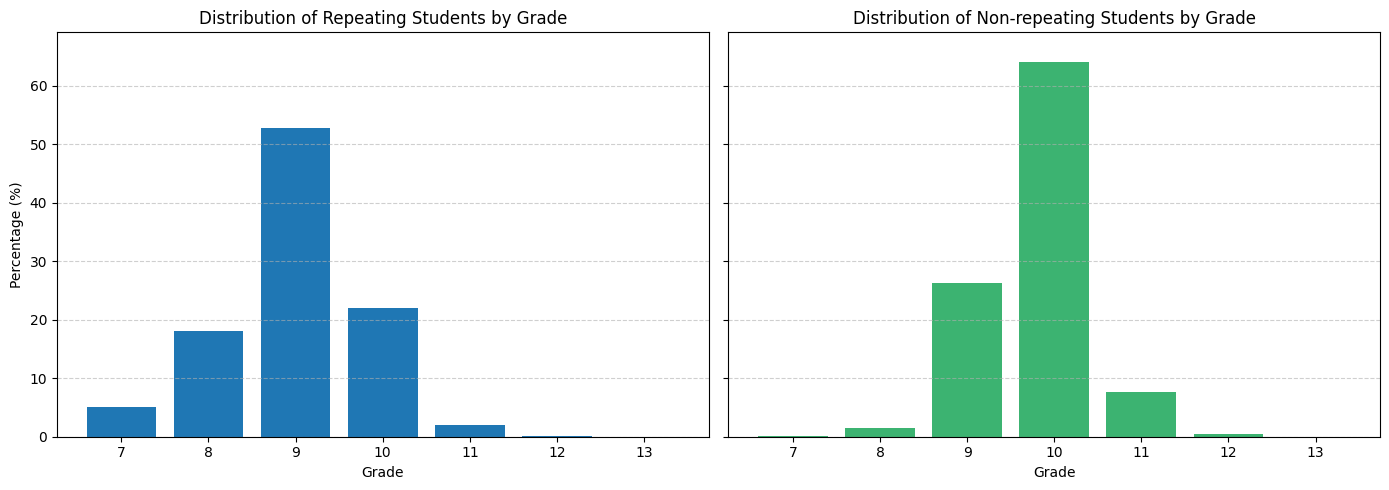

In [11]:
import matplotlib.pyplot as plt

grades = [7, 8, 9, 10, 11, 12, 13]

repeating_counts = [
    len(grade_7_repeating),
    len(grade_8_repeating),
    len(grade_9_repeating),
    len(grade_10_repeating),
    len(grade_11_repeating),
    len(grade_12_repeating),
    len(grade_13_repeating),
]

not_repeating_counts = [
    len(grade_7_not_repeating),
    len(grade_8_not_repeating),
    len(grade_9_not_repeating),
    len(grade_10_not_repeating),
    len(grade_11_not_repeating),
    len(grade_12_not_repeating),
    len(grade_13_not_repeating),
]

total_repeating = sum(repeating_counts)
total_not_repeating = sum(not_repeating_counts)

repeating_percent = [
    r / total_repeating * 100 if total_repeating > 0 else 0 for r in repeating_counts
]
not_repeating_percent = [
    nr / total_not_repeating * 100 if total_not_repeating > 0 else 0
    for nr in not_repeating_counts
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(grades, repeating_percent)
axes[0].set_title("Distribution of Repeating Students by Grade")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_xticks(grades)
axes[0].set_ylim(0, max(max(repeating_percent), max(not_repeating_percent)) + 5)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

axes[1].bar(grades, not_repeating_percent, color="mediumseagreen")
axes[1].set_title("Distribution of Non-repeating Students by Grade")
axes[1].set_xlabel("Grade")
axes[1].set_xticks(grades)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

If we separate the more advanced grades (11th, 12th and 13th) by country, we can clearly observe that the majority of students are English.

This can be justified because of the way that the english teaching system works. See: https://b28mathstutor.co.uk/how-the-english-school-system-works/#:~:text=Unlike%20in%20some%20countries%2C%20students,1%2C%20also%20known%20as%20Infants

This difference may lead to a disproportionate representation of students and we should consider them as an exception in the next phase.

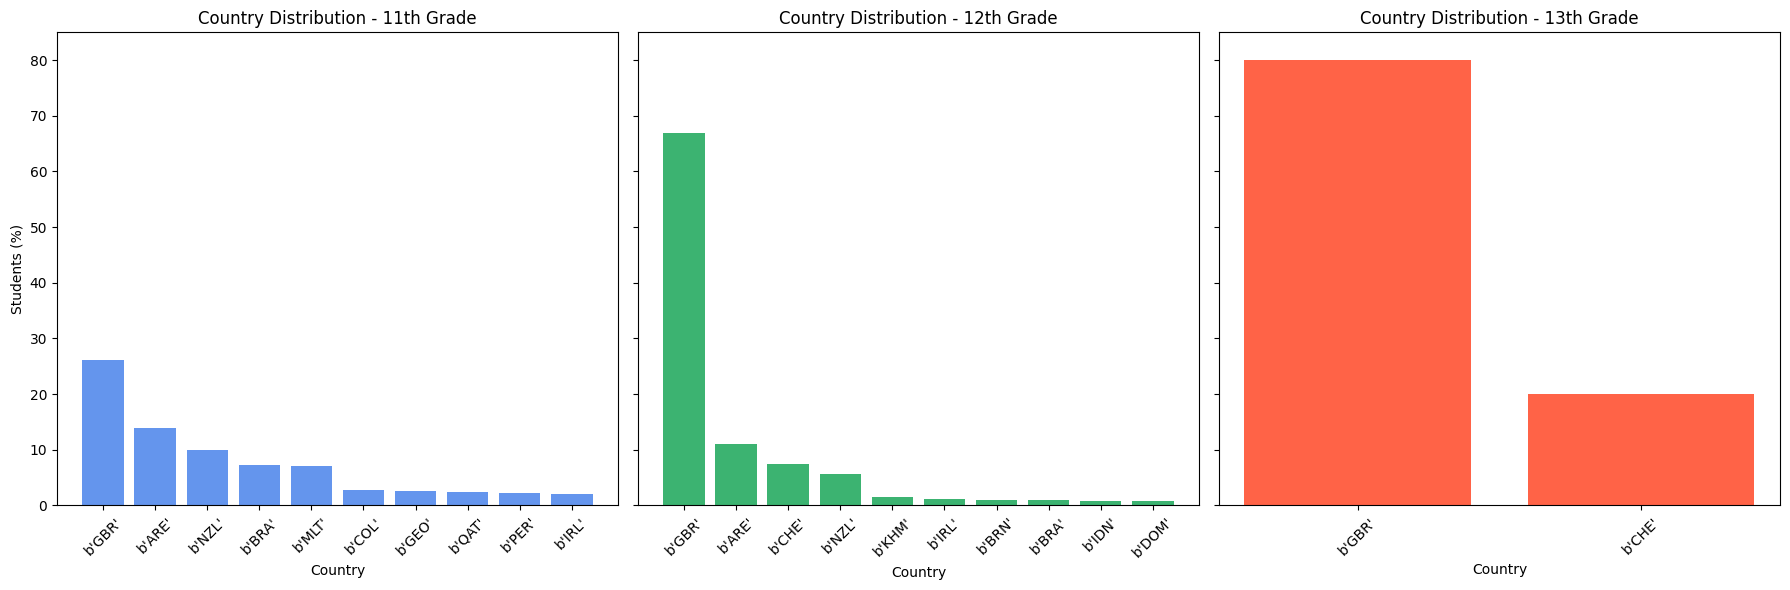

In [12]:
import matplotlib.pyplot as plt

grade_11 = filter_by_grade(student, 11)
grade_12 = filter_by_grade(student, 12)
grade_13 = filter_by_grade(student, 13)

grade_11_counts = grade_11["CNT"].value_counts(normalize=True).mul(100).head(10)
grade_12_counts = grade_12["CNT"].value_counts(normalize=True).mul(100).head(10)
grade_13_counts = grade_13["CNT"].value_counts(normalize=True).mul(100).head(10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].bar(grade_11_counts.index, grade_11_counts.values, color="cornflowerblue")
axes[0].set_title("Country Distribution - 11th Grade")
axes[0].set_xlabel("Country")
axes[0].set_ylabel("Students (%)")
axes[0].tick_params(axis="x", rotation=45)
axes[0].set_ylim(
    0, max(grade_11_counts.max(), grade_12_counts.max(), grade_13_counts.max()) + 5
)

axes[1].bar(grade_12_counts.index, grade_12_counts.values, color="mediumseagreen")
axes[1].set_title("Country Distribution - 12th Grade")
axes[1].set_xlabel("Country")
axes[1].tick_params(axis="x", rotation=45)

axes[2].bar(grade_13_counts.index, grade_13_counts.values, color="tomato")
axes[2].set_title("Country Distribution - 13th Grade")
axes[2].set_xlabel("Country")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

It is also essential to examine the correlation between all dataset features and the target variable (Avg Math Result). This helps identify which features are strongly associated with students performance and can be considered in the next step for feature selection.

We computed this correlation, and the top 20 features were visualized in a table.

In [13]:
correl = (
    student.corr(numeric_only=True)["Avg Math Result"]
    .abs()
    .sort_values(ascending=False)
)

In [15]:
top_corr = correl.drop("Avg Math Result").head(20)

top_corr_df = top_corr.reset_index()
top_corr_df.columns = ["Feature", "Correlation with Math Result"]
display(top_corr_df)

,Feature,Correlation with Math Result
0,PV1MCQN,0.929339
1,PV4MCQN,0.929264
2,PV2MCQN,0.929218
3,PV7MCQN,0.929172
4,PV3MCQN,0.929133
5,PV10MCQN,0.929110
6,PV6MCQN,0.929085
7,PV5MCQN,0.929064
8,PV9MCQN,0.928844
9,PV8MCQN,0.928833


The top features obtained are plausible values, which can be averaged, similar to the approach we used to calculate the Math Result.

Some of these features represent subscales of mathematics, and can be removed from the dataset in the next phase, as they are already captured by the aggregated Math Result score.

### Categorical Values analysis 


Regarding the categorical values, there are a few of them that are country specific. Since this study focuses on identifying global trends, we chose not to include these variables in our analysis.

Country specific codes:

- ST250D06JA
- ST250D07JA
- ST251D08JA
- ST251D09JA
- ST330D10WA 
- PROGN

Additionally, the codes "CNT", "NatCen", "STRATUM" and "SUBNATION" are all related to the student's country/region. To reduce the dimensionality of the dataset, we decided to retain only "CNT", as it effectively aggregates the information from the others.

"COBN_S", "COBN_M" and "COBN_F" represent the country of birth of the student, mother and father, respectively. This were excluded to avoid increasing the dimensionality with features that are strongly correlated with "CNT".

"OCOD1", "OCOD2" and "OCOD3" represent the occupation of the student, mother and father. While potentially insightful, occupational data can be highly country-dependent due to cultural and economic differences. For this reason, we chose not to include them in the current analysis.

Finally, "VER_DAT" was removed, as it only contains the questionnaire date, which is not relevant to our study.


"CNT" (Country) is the only remaining categorical variable, but it contains a large number of distinct values, and it needs to be grouped into fewer categories to avoid high dimensionality in future approaches such as One-Hot Encoding.

## 2.4 Verify data quality

In this step we started by checking missing values in the dataset.

We've decided that variables with more than 70% missing data can lead to biased results, so they should be removed from the dataset in the future.

In [7]:
print("\n--- Missing Values ---")
missing = student.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0.7])


--- Missing Values ---
ST326Q10JA    0.975654
ST326Q11JA    0.974807
ST326Q08JA    0.974330
ST326Q12JA    0.974207
ST326Q09JA    0.974018
                ...   
FLSCHOOL      0.733045
FL166Q01HA    0.732988
FL164Q01HA    0.731725
FL164Q09HA    0.730854
FCFMLRTY      0.721692
Length: 369, dtype: float64


We've also done a sanity check to see if there were any duplicated rows or columns, but there were no cases in this dataset.

In [9]:
print("\n--- Duplicated Rows ---")
duplicated_rows = student.duplicated().sum()
print(f"Duplicated rows: {duplicated_rows}")

print("\n--- Duplicated Columns ---")
duplicated_columns = student.T.duplicated().sum()
print(f"Duplicated columns: {duplicated_columns}")



--- Duplicated Rows ---
Duplicated rows: 0

--- Duplicated Columns ---
Duplicated columns: 0
